This notebook examines several clustering techniques to compare their ability to retrieve structure across a set of variables.


In [1]:
import hdbscan
import numpy
import pandas
import sklearn.preprocessing
import sklearn.cluster
from sklearn.metrics import adjusted_rand_score as adjrand

# We set up an R function to generate data using the lavaan simulateData function. 
# We are simulating the example from the lavaan manual, which is a CFA model with 
# three correlated factors associated with three different variables each.
from mkSemSim import simulateData

import igraph
import louvain
import scipy.stats
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline


Set up our clustering techniques.  In addition to the interesting techniques, we also run kmeans, mostly as a comparison; it's not a suitable technique for our problem since we don't know the number of clusters a priori.

In [2]:
hdbscan = hdbscan.HDBSCAN(min_cluster_size=2)
ap=sklearn.cluster.AffinityPropagation()
km=sklearn.cluster.KMeans(n_clusters=3) # assume we know the right number of clusters - which we don't!

Now we loop through a bunch of simulated datasets, and estimate the clustering for each. We assess the clustering using the adjusted Rand coefficient, which is invariant to reordering.

In [3]:
def simulate_and_score(n=200,scale_data=True,graph_density=80,noise_sd=1.0):
    """ function to generate data and return scores for each metric"""
    true_groups=numpy.array([1,1,1,2,2,2,3,3,3])
    # generate simulated data
    data=simulateData(n=n)
    data=data+numpy.random.randn(data.shape[0],data.shape[1])*noise_sd
    # scale each variable to standard normal
    # NB: infomap seems to fail with unscaled data
    if scale_data:
        data=sklearn.preprocessing.scale(data)
    
    cl_hdbscan=hdbscan.fit_predict(data)
    cl_ap=ap.fit_predict(data)
    cl_kmeans=km.fit_predict(data)
    
    # generate an adjacency matrix to create graph representation
    adj=numpy.corrcoef(data)
    triu=numpy.triu_indices_from(adj,1)
    tril=numpy.tril_indices_from(adj)
    # generate thresholded/binarized version with specified density
    cutoff=scipy.stats.scoreatpercentile(adj[triu],graph_density)
    adj_thresh=adj>cutoff
    adj_thresh[tril]=0

    # compute graph-based partitions using infomap and multilevel modularity-based method
    G = igraph.Graph.Weighted_Adjacency(adj.tolist())
    part_mod = louvain.find_partition(G, method='Modularity', weight='weight')
    part_im=G.community_infomap(edge_weights='weight')
    # multilevel requires binary graph
    G_thresh = igraph.Graph.Weighted_Adjacency(adj_thresh.tolist()).as_undirected()
    part_mlt=G_thresh.community_multilevel()
    return [adjrand(true_groups,cl_hdbscan),
                    adjrand(true_groups,cl_ap),
                    adjrand(true_groups,part_mod.membership),
                    adjrand(true_groups,part_im.membership),
                    adjrand(true_groups,part_mlt.membership),
                     adjrand(true_groups,cl_kmeans) ]

nruns=1000
randscores={}
noiselevels=[0,0.5,1.0,1.5,2.0]

for noise_sd in noiselevels:
    randscores[noise_sd]=[]
    for r in range(nruns):
        output=simulate_and_score(noise_sd=noise_sd)
        randscores[noise_sd].append(output)

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: This is lavaan 0.5-20

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: lavaan is BETA software! Please report any bugs.

  warnings.warn(x, RRuntimeWarning)


Show the mean performance for each technique, sorted by performance

In [4]:
results_df=pandas.DataFrame(numpy.vstack(([numpy.mean(randscores[i],0).T for i in noiselevels])),
                            index=noiselevels,
                            columns=['HDBSCAN','Affinity Propagation',
                                   'Louvain (weighted)','Infomap',
                                   'Louvain (binary)','KMeans (3 clusters)'])


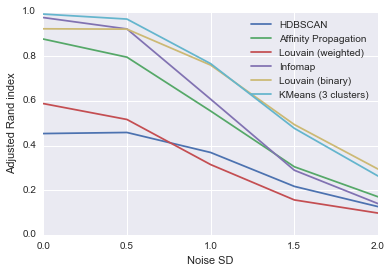

In [5]:
plt.plot(results_df)
plt.xlabel('Noise SD')
plt.ylabel('Adjusted Rand index')
plt.legend(results_df.columns)